# Titanic dataset explanatory analysis

In [496]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data.csv")

# df.head()

survival - Survival (0 = No; 1 = Yes)  
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)  
name - Name  
sex - Sex  
age - Age  
sibsp - Number of Siblings/Spouses Aboard  
parch - Number of Parents/Children Aboard  
ticket - Ticket Number  
fare - Passenger Fare  
cabin - Cabin  
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)  

In [497]:
#check data types and null values 
# df.info()

In [498]:
print('Total of passengers: {:.0f}' .format(df['PassengerId'].count()))
print()
print('Percentage of survivors: {:.0f}%' .format(df['Survived'].value_counts()[1] / df['PassengerId'].count()*100))

Total of passengers: 891

Percentage of survivors: 38%


In [499]:
# seperate data into numerical and categorical parts
df_num = df[['Age','SibSp','Parch','Fare']]
df_cat = df[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

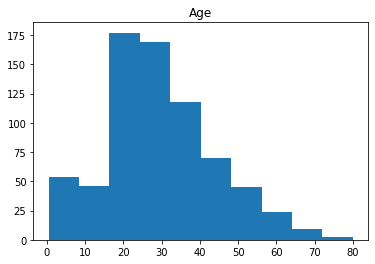

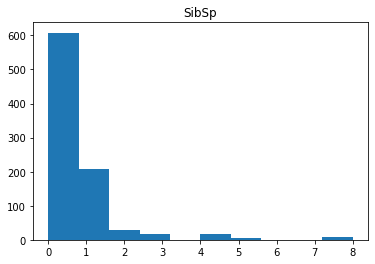

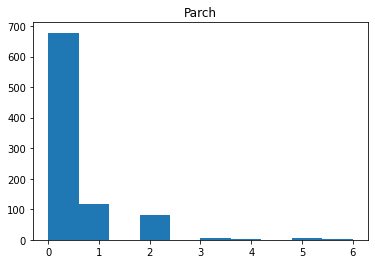

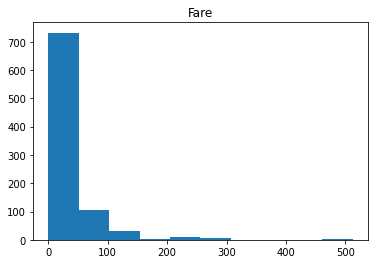

In [500]:
# numeric values distributions
for i in df_num.columns:
    # plt.hist(df_num['Age'])
    plt.hist(df_num[i])
    plt.title(i)
    # show currently active figure objects
    plt.show()

In this initial approach, we can already get an idea of the age distribution: most passengers are between 20 and 40 years old. 
From the 'SibSp' and 'Parch' data we can conclude that most people were traveling alone.
The 'Fare' graph is not very conclusive so a more in-depth analysis will follow.

In [501]:
# analysing the fares per class type
# pivot table calculates the average by default
class_fare = df.pivot_table(index='Pclass', values='Fare')
print(class_fare)

             Fare
Pclass           
1       84.154687
2       20.662183
3       13.675550


With this pivot table, we get an estimate of the prices for each ticket class.

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

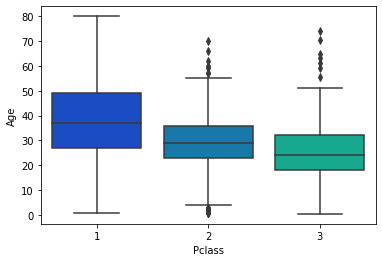

In [502]:
sns.boxplot(x='Pclass',y='Age',data=df ,palette='winter')

This box plot shows us the age distribution for each ticket class and we can see that older passengers tend to buy first-class tickets which makes sense considering that they usually have more economic power and value comfort more.

In [503]:
# compare averages of the numerical data of the survivors/not survivors
pd.pivot_table(df, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


The most relevant aspect of this pivot table is that the survivors are associated with a higher average 'Fare'. We will explore this further below.

In [504]:
# since the aggfunc is 'count' the 'values' needs to be a column of data without 
# missing values so it can count every entry. The 'Ticket' or 'PassengerId' do the job
pivot_class = pd.pivot_table(df, index = 'Survived', columns = 'Pclass', values = 'PassengerId', aggfunc = 'count')
print(pivot_class)
print()
print('Percentage of survivors by ticket class:')
print()
print('1st: {:.0f}%' .format(pivot_class[1][1]/sum(pivot_class[1])*100))
print('2nd: {:.0f}%' .format(pivot_class[2][1]/sum(pivot_class[2])*100))
print('3rd: {:.0f}%' .format(pivot_class[3][1]/sum(pivot_class[3])*100))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Percentage of survivors by ticket class:

1st: 63%
2nd: 47%
3rd: 24%


With this, we can indeed confirm that passengers with more expensive tickets had greater survival rates and that the opposite is true for cheaper tickets.

Text(0.5, 1.0, 'Pclass')

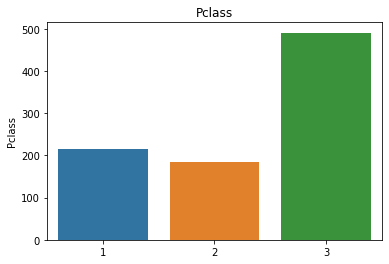

In [505]:
sns.barplot(df_cat['Pclass'].value_counts().index, df_cat['Pclass'].value_counts()).set_title('Pclass')

Here we can see that most of the tickets sold were third class, which can make sense considering that they are the most affordable.

Text(0.5, 1.0, 'Sex')

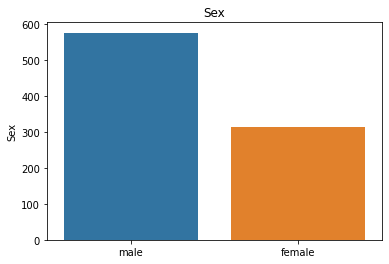

In [506]:
sns.barplot(df_cat['Sex'].value_counts().index, df_cat['Sex'].value_counts()).set_title('Sex')

In this bar plot we can see the great discrepancy between men and women on the ship. This can be explained by the fact that most of the passengers could be traveling for professional reasons and by the low percentage of working women that existed at the time.

In [507]:
pivot_sex = pd.pivot_table(df, index = 'Survived', columns = 'Sex', values = 'PassengerId', aggfunc ='count')
print(pivot_sex)
print()
print('Male survival rate: {:.0f}%' .format(pivot_sex['male'][1]/sum(pivot_sex['male'])*100))
print()
print('Female survival rate: {:.0f}%' .format(pivot_sex['female'][1]/sum(pivot_sex['female'])*100))
print()
print('{:.0f}% of the rescued passengers were women.' .format(pivot_sex['female'][1]/(pivot_sex['male'][1]+pivot_sex['female'][1])*100))

Sex       female  male
Survived              
0             81   468
1            233   109

Male survival rate: 19%

Female survival rate: 74%

68% of the rescued passengers were women.


This large survival rate of women can be explained by the priority given to them when abandoning the ship.

Text(0.5, 1.0, 'Embarked')

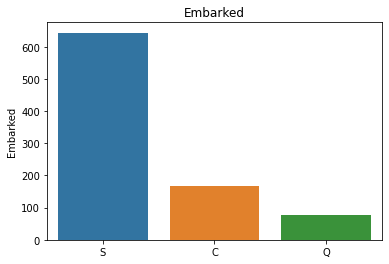

In [508]:
sns.barplot(df_cat['Embarked'].value_counts().index, df_cat['Embarked'].value_counts()).set_title('Embarked')

Most passengers boarded in Southampton, which may imply that this was the place of departure.

# Model

## Preprocessing

### Find the null values

In [509]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [510]:
# deleting column 'Cabin' because of the many null values
# an analysis could be on the cabin locations inside the ship but 
# due to the many null values there are other priority approaches
# axis = 1 to delete the entire column
post_proc=df.drop(columns=['Cabin'], axis=1)
# deleting 'Name', IDs and 'Ticket' because they are not relevant for the model
post_proc=post_proc.drop(columns=['PassengerId'], axis=1)
post_proc=post_proc.drop(columns=['Ticket'], axis=1)
post_proc=post_proc.drop(columns=['Name'], axis=1)

In [511]:
# fill 'Age' missing values with the mean of the respective column
post_proc['Age']=post_proc['Age'].fillna(df['Age'].mean())

In [512]:
# fill 'Embarked' missing values
# since it is only two values we can just use the mode of the respective column
post_proc['Embarked']=post_proc['Embarked'].fillna(df['Embarked'].mode()[0])

### Correlation Matrix

<AxesSubplot:>

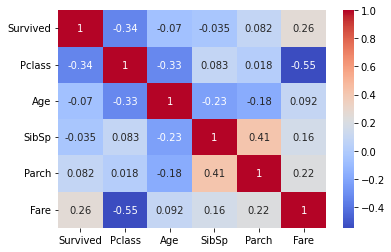

In [513]:
corr = post_proc.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

The Correlation Matrix shows us the correlation between the various features, which can help us understand which features are most relevant to the model. 

In this case, we can observe decent correlations between the features 'Pclass',  'Fare' and 'Age' that have already been explained above. 

However, for the model itself, the most relevant aspect to highlight is the correlation between the 'Survived' feature and the 'Fare' and 'Pclass' features that will lead the model to consider survivors passengers with the most expensive tickets, going along what we saw above.

### Label Encoding

In [514]:
# transforming categorical data into integers
from sklearn.preprocessing import LabelEncoder
cols = ['Sex', 'Embarked']

for col in cols:
    post_proc[col] = LabelEncoder().fit_transform(post_proc[col])

# Male -> 1
# Female -> 0
# C -> 0
# Q -> 1
# S -> 2

## Training and classification results

In [515]:
# labels: only the 'Survived' column
y = post_proc['Survived']
# features: every column except 'Survived'
X = post_proc.drop(columns=['Survived'], axis=1)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

def classify(model):
    print()
    model.fit(X_train, y_train)
    print('Accuracy: {:.2f}%'.format(model.score(X_val, y_val)*100))
    print()
    from sklearn.metrics import confusion_matrix
    cm = pd.DataFrame(confusion_matrix(y_val,model.predict(X_val)))
    # plot confusion matrix
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt = ".0f")
    ax.set_title('Confusion Matrix - {}'.format(model))
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])


Accuracy: 80.72%



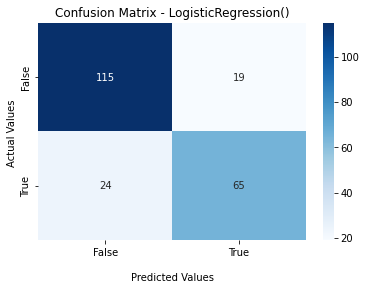

In [516]:
from sklearn.linear_model import LogisticRegression
classify(LogisticRegression())

In [517]:
#from sklearn.svm import SVC, LinearSVC
#classify(SVC())
#classify(LinearSVC())

In [518]:
#from sklearn.neighbors import KNeighborsClassifier
#classify(KNeighborsClassifier(n_neighbors = 3))

In [519]:
#from sklearn.naive_bayes import GaussianNB
#classify(GaussianNB())

In [520]:
#from sklearn.tree import DecisionTreeClassifier
#classify(DecisionTreeClassifier())

In [521]:
#from sklearn.ensemble import RandomForestClassifier
#classify(RandomForestClassifier(n_estimators=100))